## My Policy gradient

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

Run a ChildNet architecture and obtain the reward

In [2]:
from MychildNet import ChildNet


cn = ChildNet()
nb_epochs = 100

cn.compute_reward([0,3,7],[0,1,2], nb_epochs)

0.5005999803543091

Define the Policy Net and its loss (controller loss)

In [3]:
batch_size = 15
learning_rate = 1e-2
n_hidden = 24
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_hidden, learning_rate, layer_limit):
        super(PolicyNet, self).__init__()
        
        self.layer_limit = layer_limit
        self.gamma = 1.0
        
        self.lstm1 = nn.LSTMCell(5, n_hidden)
        self.lstm2 = nn.LSTMCell(6, n_hidden)
        self.layer_hid_nodes = nn.Linear(n_hidden, 6)
        self.layer_act_func = nn.Linear(n_hidden, 5)
        
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def one_hot(self, t, num_classes):
        out = np.zeros((t.shape[0], num_classes))
        for row, col in enumerate(t):
            out[row, col] = 1
        return out.astype('float32')

    def sample_action(self, output, training):
        if training:
            random_array = np.random.rand(batch_size).reshape(batch_size,1)
            return (np.cumsum(output.detach().numpy(), axis=1) > random_array).argmax(axis=1) # sample action
        else: #eval
            return (output.detach().numpy()).argmax(axis=1)
                
    def forward(self, training):
        outputs = []
        outputs_hid_nodes = []
        outputs_act_functions = []
        prob_hid_nodes = []
        prob_act_functions = []
        prob = []
        actions_hid_nodes = np.zeros((batch_size, self.layer_limit))
        actions_act_functions = np.zeros((batch_size, self.layer_limit))
        #action_act_functions = not None #initialize action to don't break the while condition 
        action_act_functions = torch.zeros(batch_size, 5, dtype=torch.float)
        i = 0
        counter_nb_layers = 0
        
        h_t = torch.zeros(batch_size, n_hidden, dtype=torch.float)
        c_t = torch.zeros(batch_size, n_hidden, dtype=torch.float)
        #action = torch.zeros(batch_size, n_outputs, dtype=torch.float)
        
        #h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        #c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        
        while counter_nb_layers<2*self.layer_limit: 
            #print(counter_nb_layers)
            #得到输出和记忆
            #h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            if counter_nb_layers % 2 == 0:
                h_t, c_t = self.lstm1(action_act_functions, (h_t, c_t))
                output_hid_nodes = F.softmax(self.layer_hid_nodes(h_t))
                action_hid_nodes = self.sample_action(output_hid_nodes, training)
                outputs_hid_nodes += [output_hid_nodes]
                prob_hid_nodes.append(output_hid_nodes[np.arange(batch_size),action_hid_nodes])
                
                actions_hid_nodes[:,i//2] = action_hid_nodes
                #print(actions_hid_nodes)
                action_hid_nodes = torch.tensor(self.one_hot(action_hid_nodes, 6))
            else:
                h_t, c_t = self.lstm2(action_hid_nodes, (h_t, c_t))
                output_act_functions = F.softmax(self.layer_act_func(h_t))
                action_act_functions = self.sample_action(output_act_functions, training)
                outputs_act_functions += [output_act_functions]
                prob_act_functions.append(output_act_functions[np.arange(batch_size),action_act_functions])
                actions_act_functions[:, i//2] = action_act_functions
                action_act_functions = torch.tensor(self.one_hot(action_act_functions, 5))   
            counter_nb_layers += 1
            #选新的动作         
            i += 1
            
        prob_act_functions = torch.stack(prob_act_functions, 1)
        outputs_act_functions = torch.stack(outputs_act_functions, 1).squeeze(2)
        prob_hid_nodes = torch.stack(prob_hid_nodes, 1)
        outputs_hid_nodes = torch.stack(outputs_hid_nodes, 1).squeeze(2)
        #outputs.view(-1, n_outputs)
        
        return prob_act_functions,prob_hid_nodes, actions_act_functions,actions_hid_nodes

    def loss(self, action_probabilities_a,action_probabilities_h, returns, baseline):        
        #T is the number of hyperparameters 
        sum_over_T_a = torch.sum(torch.log(action_probabilities_a.view(batch_size, -1)), axis=1)
        sum_over_T_h = torch.sum(torch.log(action_probabilities_h.view(batch_size, -1)), axis=1)
        subs_baseline = torch.add(returns,-baseline)
        res = torch.mean(torch.mul(sum_over_T_a, subs_baseline)) - torch.sum(torch.mul (torch.tensor(0.01) * action_probabilities_a, torch.log(action_probabilities_a.view(batch_size, -1))))
        res +=torch.mean(torch.mul(sum_over_T_h, subs_baseline)) - torch.sum(torch.mul (torch.tensor(0.01) * action_probabilities_h, torch.log(action_probabilities_h.view(batch_size, -1))))
        return res


Helper functions

In [4]:
def indexes_to_actions(prob_a,prob_h,actions_act_functions,actions_hid_nodes,layer_limit):
    e = [(0,1),(0,2),(0,3),(0,4),(0,5),(1,2),(1,3),(1,4),(1,5),(2,3),(2,4),(2,5),(3,4),(3,5),(4,5)]
    #print(actions_act_functions)
    #print(actions_hid_nodes)
    batch_edges = []
    batch_acts = []
    batch_prob_a = []
    batch_prob_h = []
    for b in range(batch_size):
        pre = 0
        temp_edges = []
        temp_acts = []
        temp_prob_a = []
        temp_prob_h = []
        for i in range(layer_limit):
            if actions_hid_nodes[b][i] > pre:
                for t,(x,y) in enumerate(e):
                    if x == pre and y == actions_hid_nodes[b][i]:
                        temp_edges.append(t)
                        pre = actions_hid_nodes[b][i]
                        temp_acts.append(actions_act_functions[b][i])
                        temp_prob_a.append(prob_a[b][i])
                        temp_prob_h.append(prob_h[b][i])
                        break
        if pre != 5:
            for t,(x,y) in enumerate(e):
                    if x == pre and y == 5:
                        temp_edges.append(t)
                        temp_acts.append(actions_act_functions[b][4])
                        temp_prob_a.append(prob_a[b][4])
                        temp_prob_h.append(prob_h[b][4])
                        pre = 5
                        break
            #temp_acts.append(actions_act_functions[b][4])
        batch_edges.append(temp_edges)
        batch_acts.append(temp_acts)
        batch_prob_a.append(temp_prob_a)
        batch_prob_h.append(temp_prob_h)
    return batch_prob_a,batch_prob_h,batch_edges,batch_acts
    
def fill_tensor(tensor_to_fill, size, ones=True):
    if len(tensor_to_fill.size()) >= 2: #dim >= 2
        tensor_to_fill = tensor_to_fill.view(-1)
    
    if ones:
        #fill with ones, useful if afterwards it will be applied log (log 1 = 0, log 0 = -inf)
        size_remaining = size - tensor_to_fill.size()[0]
        return torch.cat((tensor_to_fill, torch.ones(size_remaining)))
    else:        
        size_remaining = size - tensor_to_fill.size()[0]
        return torch.cat((tensor_to_fill, torch.zeros(size_remaining)))

Test Forward pass


In [5]:
#np.cumsum(outputs[:,0].detach().numpy(), axis=1) > random_array.argmax(axis=1)

In [6]:
policy = PolicyNet(n_hidden, learning_rate, layer_limit=5)
prob_a,prob_h, actions_a,actions_h = policy(True)
#prob_a,prob_h, actions_a,actions_h, indexes_to_actions(prob_a,prob_h,actions_a,actions_h,layer_limit=5)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [7]:
prob_a[0],prob_a[1]

(tensor([0.1774, 0.1794, 0.1756, 0.2445, 0.2466], grad_fn=<SelectBackward>),
 tensor([0.1797, 0.2104, 0.2187, 0.2394, 0.2467], grad_fn=<SelectBackward>))

In [8]:
print(policy)

PolicyNet(
  (lstm1): LSTMCell(5, 24)
  (lstm2): LSTMCell(6, 24)
  (layer_hid_nodes): Linear(in_features=24, out_features=6, bias=True)
  (layer_act_func): Linear(in_features=24, out_features=5, bias=True)
)


Train the policy

In [11]:
# training settings
torch.set_num_threads(8)
num_episodes = 500
decay = 0.9
verbose = False
# setup policy network

policy = PolicyNet(n_hidden, learning_rate, layer_limit=5)
baseline = torch.zeros(15, dtype=torch.float)

# train policy network

try:
    training_rewards, val_rewards, losses = [], [], []
    baseline = torch.zeros(15, dtype=torch.float)
    print('start training')
    for i in range(num_episodes):
        rollout, batch_r, batch_a_probs_a,batch_a_probs_h = [], [], [], []
        training = True
        with torch.no_grad():
            prob_a,prob_h, actions_a,actions_h = policy(training)
        prob_a,prob_h,batch_edges,batch_acts = indexes_to_actions(prob_a,prob_h,actions_a,actions_h,layer_limit=5)
        #batch_hid_units, batch_index_eos = indexes_to_actions(actions)
        for j in range(batch_size):
            # policy gradient update 
            #print(batch_edges[j],batch_acts[j])
            r = cn.compute_reward(batch_edges[j],batch_acts[j], nb_epochs)**3
            if batch_edges[j] == 4:
                r -= 1
            #print(prob_a)
            a_probs_a = prob_a[j]
            a_probs_h = prob_h[j]
            batch_r += [r]
            batch_a_probs_a += [a_probs_a]
            batch_a_probs_h += [a_probs_h]
        
        a_probs_a = []
        a_probs_h = []
        for b in range(batch_size):
            a_probs_a.append(fill_tensor(torch.tensor(batch_a_probs_a[b]), 5, ones=True))
        for b in range(batch_size):
            a_probs_h.append(fill_tensor(torch.tensor(batch_a_probs_h[b]), 6, ones=True))
        a_probs_a = torch.stack(a_probs_a,0)
        a_probs_h = torch.stack(a_probs_h,0)
        batch_a_probs_a = Variable(a_probs_a, requires_grad=True)
        batch_a_probs_h = Variable(a_probs_h, requires_grad=True)
        batch_r = Variable(torch.tensor(batch_r), requires_grad=True)
        loss = policy.loss(batch_a_probs_a,batch_a_probs_h, batch_r, torch.mean(baseline))
        policy.optimizer.zero_grad()  
        loss.backward()
        policy.optimizer.step()
        
        # bookkeeping
        training_rewards.append(torch.mean(batch_r).detach().numpy())
        losses.append(loss.item())
        # actualize baseline
        baseline = torch.cat((baseline[1:]*decay, torch.tensor([torch.mean(batch_r)*(1-decay)], dtype=torch.float)))
        # print
        if verbose and (i+1) % val_freq == 0:
            print('{:4d}. mean training reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(losses[-val_freq:])))
        if i % 10 == 0:
            print(i)
        
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

start training


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
done


Plot the training losses and the training rewards

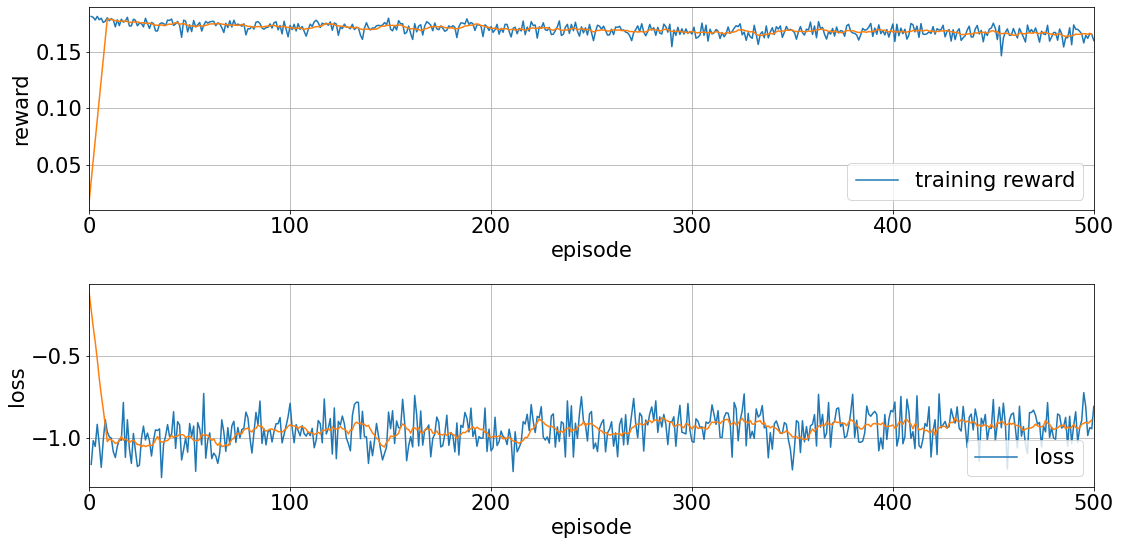

In [12]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 21})

# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,8))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))#, plt.ylim((-20,20))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); #plt.show()
plt.savefig('training.jpg')

Generate a childNet architecture and compute its reward

In [14]:
prob_a,prob_h, actions_a,actions_h = policy(training)
prob_a,prob_h,batch_edges,batch_acts = indexes_to_actions(prob_a,prob_h,actions_a,actions_h,layer_limit=5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [15]:
batch_edges[0],batch_acts[0]

([0, 6, 12, 14], [3.0, 1.0, 0.0, 3.0])

In [16]:
cn.compute_reward(batch_edges[0],batch_acts[0], nb_epochs)

0.5447999835014343

In [12]:
cn.compute_reward(['LeakyReLU', 'ReLU', 'Sigmoid', 'EOS'],nb_epochs)

0.7200000286102295

In [13]:
cn.compute_reward(['LeakyReLU', 8, 'Tanh', 32, 'EOS'], nb_epochs)

0.8600000143051147

In [14]:
torch.save(policy.state_dict(), 'policy.pt')